In [1]:
# nEpochs=20  # orig, longer training
nEpochs=3  # quick testing during development

# Select one (and only one) model to train
USE_CGAN = False
USE_CVAE = False
USE_CVAECGAN = True

# Extract model name based on boolean value above
model_name = ""
if USE_CGAN:
    model_name += "cgan"
elif USE_CVAE:
    model_name += "cvae"
elif USE_CVAECGAN:
    model_name += "cvaecgan"

# Double check model name is valid
if model_name not in {"cgan", "cvae", "cvaecgan"}:
    raise Exception("Double check you are only using one model. The current model name is invalid")

## 1. Import 3rd party libraries 

In [2]:
import os
import session_info
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

try:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    )
except:
    Warning("Unable To configure Tensorflow GPU")
    
# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional, SaveImagesConditional
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN

#session_info.show()

2025-05-30 13:05:31.161184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748628331.454956     681 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748628331.559489     681 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748628332.044851     681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748628332.044890     681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748628332.044892     681 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Show some our data

I0000 00:00:1748628342.561391     681 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3300 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


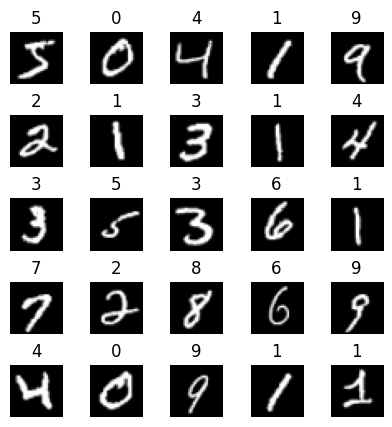

In [3]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist' + f"_hpo_{model_name}"
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [4]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
hpo_params = {
    'n_latent_dims' : 4,
    'learning_rate': 0.001,
    'encoder_params' : {
        'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4,4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'generator_params' : {
        'generator_conv_layer_units' : [128,128],
        'generator_conv_layer_kernel_size' : [4,4],
        'generator_conv_layer_strides' : [(2,2), (2,2)],
        'generator_conv_layer_activation_functions' : [tf.nn.leaky_relu,tf.nn.leaky_relu],
        'discriminator_dense_layer_units' : [128],
        'generator_dense_layer_units' : [],
    },
    'discriminator_params' : {
        'discriminator_conv_layer_units' : [32,64],
        'discriminator_conv_layer_kernel_size' : [4,4],
        'discriminator_conv_layer_strides' : [(1,1), (2,2)],
        'discriminator_conv_layer_activation_functions' : ['relu','relu'],
        'discriminator_dense_layer_units' : [],
        'generator_dense_layer_units' : [],
    }
}

if USE_CGAN:
    model = ConditionalGAN(n_classes=n_classes,
                                 n_latent_dims = hpo_params['n_latent_dims'],
                                 generator_params = hpo_params['generator_params'],
                                 discriminator_params = hpo_params['discriminator_params'])
if USE_CVAE:
    model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'],
    )
if USE_CVAECGAN:
    model = ConditionalVAECGAN(adv_loss_weight=10., 
                            n_classes=n_classes,
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params=hpo_params['encoder_params'],
                            decoder_params=hpo_params['decoder_params'],
                            discriminator_params=hpo_params['discriminator_params']
    )


# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.

# All three models will use this input structure
# model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
# if USE_CVAE or USE_CVAECGAN:
#     model.decoder.compute_output_shape((None, n_classes + model.n_latent_dims))
# if USE_CGAN or USE_CVAECGAN:
#     model.discriminator.compute_output_shape((None, 32, 32, 1))

In [5]:
print("=== OVERALL MODEL ====")
model.summary()

if USE_CGAN:
    print("=== GENERATOR SUBMODEL ====")
    gen_in = tf.keras.layers.Input(model.n_latent_dims+model.n_classes)
    gen_out  = model.generator.call(gen_in) 
    gen = tf.keras.Model(gen_in, gen_out) 
    gen.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()
if USE_CVAE:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input(model.n_latent_dims+model.n_classes) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
if USE_CVAECGAN:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input(shape=(model.n_latent_dims + model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()


=== OVERALL MODEL ====


Model: "cvaecgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator                   │ ?                      │   0 (unbuilt) │
│ (MultiTaskDiscriminator)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== ENCODER SUBMODEL ====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │      2,832 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │         64 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     16,448 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense0 (Dense)      │ (None, 128)       │  2,097,280 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_mean (Dense)  │ (None, 4)         │        516 │ dense0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_logvar        │ (None, 4)         │        516 │ dense0[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,117,912 (8.08 MB)

 Trainable params: 2,117,752 (8.08 MB)

 Non-trainable params: 160 (640.00 B)

=== DECODER SUBMODEL ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_to_conv (Dense)           │ (None, 16384)          │       245,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv1 (Conv2DTranspose)        │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv0 (Conv2DTranspose)        │ (None, 32, 32, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 32, 32, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (Activation)              │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,097 (1.25 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 160 (640.00 B)

=== DISCRIMINATOR SUBMODEL ====


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │        544 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │        128 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     32,832 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_real (Dense)  │ (None, 1)         │     16,385 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_class (Dense) │ (None, 10)        │    163,850 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_real        │ (None, 1)         │          0 │ dense_real[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_class       │ (None, 10)        │          0 │ dense_class[0][0] │
│ (Softmax)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,995 (835.92 KB)

 Trainable params: 213,803 (835.17 KB)

 Non-trainable params: 192 (768.00 B)

In [6]:
_ = model([data.images_train[:1], labels_onehot[:1]])

/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'cvaecgan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1748616284.758304   16959 cuda_dnn.cc:529] Loaded cuDNN version 90300


## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 

model.compile(optimizer_encoder=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']),
              optimizer_decoder=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']),
              optimizer_discriminator=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
if USE_CGAN:
    save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                    model=model,
                                                    example_labels=labels_onehot[:10],
                                                    n_generated_images=10,
                                                    n_latent_dims=model.n_latent_dims)
elif USE_CVAE or USE_CVAECGAN:
    save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                model=model,
                                                example_images=data.images_train[:10],
                                                example_labels=labels_onehot[:10],
                                                n_generated_images=10,
                                                n_latent_dims=model.n_latent_dims)



## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/3


I0000 00:00:1748616294.174569   17409 service.cc:152] XLA service 0x2aae840081e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748616294.174615   17409 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 3.8684 - dec_loss: 161.6475 - disc_loss: 4.7028 - enc_loss: 885.0644 - kl_loss: 718.4051 - recon_loss: 166.6593 - top_1_acc: 0.1506 

I0000 00:00:1748616303.520199   17409 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - class_loss: 0.4876 - dec_loss: 59.3963 - disc_loss: 0.5199 - enc_loss: 148.5289 - kl_loss: 89.5254 - recon_loss: 59.0035 - top_1_acc: 0.8843
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0603 - dec_loss: 35.3878 - disc_loss: 0.0611 - enc_loss: 42.5202 - kl_loss: 7.1732 - recon_loss: 35.3470 - top_1_acc: 0.9813
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0414 - dec_loss: 31.4615 - disc_loss: 0.0424 - enc_loss: 37.7693 - kl_loss: 6.3282 - recon_loss: 31.4411 - top_1_acc: 0.9866


## 8. Training saves results to disk, now also plot training curves

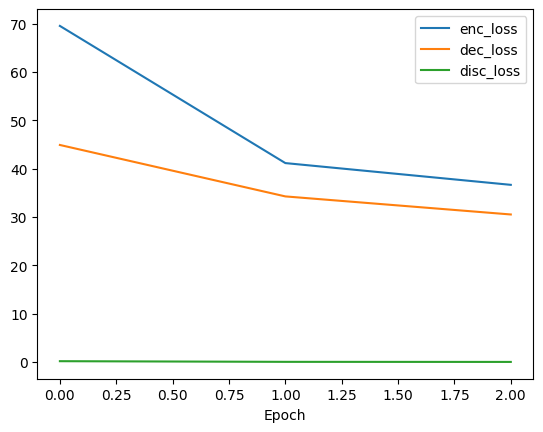

In [9]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['enc_loss', 'dec_loss', 'disc_loss', 'gen_loss']:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)
        
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
# fig.show()

# Save the model 
model.save(os.path.join(output_dir, model_name+'.keras'))


# HPO Exercise: Your Turn!
- Take the code from above, and implement a grid search over at least 2 hyper parameters (try at least 3 different values for each hyper parameter)
  - Train each model for at least 20 epochs. 
  - You can modify both hyperparameters at the same time, or perform two completely separate sequential tunings. 
  - You can find some suggested hyperparameter ranges / values in the table below:

Hyperparameter | [min value, max value]
----------------|-----------------------
Number of latent dims: |   [2, 128]
Number of Convolutional layers: |     [1, 6]
Number of convolutional layer units:|     [4, 256]
Convolutional kernel size: | [2, 5]
Convolutional layer activation functions (choose): |  ['relu', 'elu', 'linear', tf.nn.leaky_relu, 'softmax', 'sigmoid']
Dense layer units: | [4, 256]
Learning Rate:  | [0.01, 0.000001]


There are 4 cells below. The first 2 are for 3 epochs, and the last 2 are for 20 epochs.


**HPO**


I choose number of latent dim, learning rate and convolution layer activation function for hpo.
For num of latent dim, it is the bottleneck size. If it is too few of them, the infomation will be lost. And if they are too many, it will lead to meaningless the latent dimension.
For learning rate, if it is high, the training is unstable but fast while the other end will lead to the slow training and the possbility that it stays on the local suboptimal minimum.
For convolution function, Relu is computationally efficient and helps mitigate the vanishing gradient problem.  Elu has the similar effect and it helps to push the mean into 0. softmax is potentially problematic as it will restrict the representation of the layer.


In [33]:
## !!!!IMPORTANT!!!!
## Keep the seed the same across ALL HPO experiments. Be sure to reinitialize for EVERY new model.
tf.random.set_seed(1234)
## !!!!IMPORTANT!!!!
import itertools
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import datetime
import json

model_name_prefix = "CVAECGAN_MNIST" 
output_dir = "./outputs" # Root directory for saving HPO outputs
n_classes = 10 
# Instantiate a container with the hyperparameter(s) you want to test
USE_CGAN = False
USE_CVAE = False
USE_CVAECGAN = True

hpo_grid = {
    "n_latent_dims":   [4, 16, 64],
    "learning_rate":   [1e-3, 1e-4, 1e-5],
    "conv_function": ["relu", "elu",'softmax'],       
}
tf.random.set_seed(1234)
# Instantiate a model for a hyperparameter (combination)
## Note: I would recommend naming your model with the specific HPO you are trying at the moment.
keys, values = zip(*hpo_grid.items())
search_space = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total hyperparameter combinations to train: {len(search_space)}")
results = [] # To store results from each run

# Ensure the main output directory exists
os.makedirs(output_dir, exist_ok=True)

nEpochs_hpo = 3                 
batch_size = 128
for run_idx, hp in enumerate(search_space, 1):
    print("\n", "="*70)
    print(f"Let's go! [{run_idx}/{len(search_space)}] Starting HPO run with parameters:", hp)

    # Clear Keras session to ensure a clean state for each model
    tf.keras.backend.clear_session()
    # !!!!IMPORTANT!!!! Reinitialize the seed for EVERY new model for consistent weight initialization.
    tf.random.set_seed(1234)
     # Construct a unique name and output directory for this hyperparameter combination
    cname = (
        f"{model_name_prefix}"
        f"_ld{hp['n_latent_dims']}"
        f"_lr{hp['learning_rate']:.0e}" # Format learning rate in scientific notation
        f"_af{hp['conv_function']}"
    )
    combo_outdir = os.path.join(output_dir, cname)
    os.makedirs(combo_outdir, exist_ok=True)
    print(f"Output directory for this run: {combo_outdir}")

    # Path for the final model checkpoint
    checkpoint_path = os.path.join(combo_outdir, "ckpt_final.keras")

    # Skip if this combination has already been trained
    if os.path.exists(checkpoint_path):
        print(f"Skipping this combo {cname} — checkpoint already exists at {checkpoint_path}.")
        # Optionally, load results from a JSON file if you saved them previously for this run
        continue

    hpo_params2 = {
        "n_latent_dims": hp["n_latent_dims"],
        "learning_rate": hp["learning_rate"],
        "encoder_params": {
            
            'conv_layer_units' : [16,64],
            "conv_layer_kernel_size": [4, 4],
            "conv_layer_strides": [(1, 1), (2, 2)],
            "conv_layer_activation_function": [hp['conv_function']] * 2,
            "encoder_dense_layer_units": [128],
            "decoder_dense_layer_units": [],
        },
        "decoder_params": { 
            'conv_layer_units' : [16,64],
            "conv_layer_kernel_size": [4, 4],
            "conv_layer_strides": [(1, 1), (2, 2)],
            "conv_layer_activation_function":[hp['conv_function']] * 2,
            "encoder_dense_layer_units": [128],
            "decoder_dense_layer_units": [],
        },
        
        "generator_params": hpo_params["generator_params"],
        "discriminator_params": hpo_params["discriminator_params"],
    }
    
    # Build a model with input / output dimensions

    if USE_CVAECGAN:
        model = ConditionalVAECGAN(adv_loss_weight=10., 
                                n_classes=n_classes,
                                n_latent_dims = hpo_params2['n_latent_dims'],
                                encoder_params=hpo_params2['encoder_params'],
                                decoder_params=hpo_params2['decoder_params'],
                                discriminator_params=hpo_params2['discriminator_params']
        )
        
    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"])

    # Set up callbacks for this run
    callbacks = [
        CSVLogger(os.path.join(combo_outdir, "training_log.csv")), # Logs epoch results to CSV
        EarlyStopping(
            monitor="loss", # Monitor total loss; change to 'val_loss' if you have validation data in fit()
            patience=5,         # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored quantity
            verbose=1
        ),
    ]

    # Add custom image generation/saving callbacks
    if USE_CVAECGAN: # For CVAE or CVAECGAN, or any model that reconstructs
        callbacks.append(
            SaveImagesConditional( # Assuming this callback is defined
                output_dir=combo_outdir,
                model=model,
                example_images=data.images_train[:10], # Use a small sample of training images
                example_labels=labels_onehot[:10],
                n_generated_images=10,
                n_latent_dims=model.n_latent_dims,
            )
        )
            # Compile the model with appropriate optimizer(s)
    # The compilation logic depends on the model type (e.g., CVAECGAN might have multiple optimizers)
    if  USE_CVAECGAN: 
        model.compile(optimizer_encoder=tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]),
                      optimizer_decoder=tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]),
                      optimizer_discriminator=tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]))
    
    
# Fit model to the data
    history = model.fit(
        [data.images_train, labels_onehot], 
        data.images_train,
        batch_size=batch_size,
        epochs=nEpochs_hpo,
        callbacks=callbacks,
        verbose=1, # Adjust verbosity as needed (1 for progress bar, 2 for one line per epoch)
        # validation_data=([data.images_val, labels_val_onehot], data.images_val) # If you have validation data
    )
    recon_loss = history.history["recon_loss"][-1]
    kl_loss = history.history["kl_loss"][-1]
    enc_loss = history.history["enc_loss"][-1]
    dec_loss = history.history["dec_loss"][-1]
    disc_loss = history.history["disc_loss"][-1]
    results.append(
        {
            "run_name": cname,
            **hp,
            "recon_loss": float(recon_loss),
            "kl_loss": float(kl_loss),
            "enc_loss": float(enc_loss),
            "dec_loss": float(dec_loss),
            "disc_loss": float(disc_loss),
        }
    )

    model.save(os.path.join(combo_outdir, "ckpt_final.keras"))
# Plot the training curves for the model

# Save the model 

# Assuming you are using the provided callbacks and save the model/outputs appropriately,
# You should be able to use the provided `image_viewer` to look at the fakes and/or recons just by
# Passing in a model's name/directory.


Total hyperparameter combinations to train: 27

Let's go! [1/27] Starting HPO run with parameters: {'n_latent_dims': 4, 'learning_rate': 0.001, 'conv_function': 'relu'}
Output directory for this run: ./outputs/CVAECGAN_MNIST_ld4_lr1e-03_afrelu
Skipping this combo CVAECGAN_MNIST_ld4_lr1e-03_afrelu — checkpoint already exists at ./outputs/CVAECGAN_MNIST_ld4_lr1e-03_afrelu/ckpt_final.keras.

Let's go! [2/27] Starting HPO run with parameters: {'n_latent_dims': 4, 'learning_rate': 0.001, 'conv_function': 'elu'}
Output directory for this run: ./outputs/CVAECGAN_MNIST_ld4_lr1e-03_afelu
Skipping this combo CVAECGAN_MNIST_ld4_lr1e-03_afelu — checkpoint already exists at ./outputs/CVAECGAN_MNIST_ld4_lr1e-03_afelu/ckpt_final.keras.

Let's go! [3/27] Starting HPO run with parameters: {'n_latent_dims': 4, 'learning_rate': 0.001, 'conv_function': 'softmax'}
Output directory for this run: ./outputs/CVAECGAN_MNIST_ld4_lr1e-03_afsoftmax
Skipping this combo CVAECGAN_MNIST_ld4_lr1e-03_afsoftmax — checkpo

In [34]:

# Save the model 
sort_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]
top_k = 5

print("\n===== HPO Finished. Top-K Runs by Each Loss Metric =====\n")

for key in sort_keys:
    sorted_res = sorted(results, key=lambda x: x.get(key, float('inf')))
    print(f"Top-{top_k} runs sorted by {key}:")
    for rank, res in enumerate(sorted_res[:top_k], 1):
        hps = {k: res[k] for k in hpo_grid.keys()}
        loss_val = res.get(key, None)
        print(f" {rank:>2d}. {res['run_name']:35s} {key} = {loss_val:.4f} → {hps}")
    print("-" * 80)

# ---- Write all results into a JSON file ----
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
json_path = os.path.join(output_dir, f"hpo_all_losses_{ts}.json")
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\nAll HPO results saved to: {json_path}")


===== HPO Finished. Top-K Runs by Each Loss Metric =====

Top-5 runs sorted by recon_loss:
--------------------------------------------------------------------------------
Top-5 runs sorted by kl_loss:
--------------------------------------------------------------------------------
Top-5 runs sorted by enc_loss:
--------------------------------------------------------------------------------
Top-5 runs sorted by dec_loss:
--------------------------------------------------------------------------------
Top-5 runs sorted by disc_loss:
--------------------------------------------------------------------------------

All HPO results saved to: ./outputs/hpo_all_losses_20250530_122836.json


In [9]:
## !!!!IMPORTANT!!!!
## Keep the seed the same across ALL HPO experiments. Be sure to reinitialize for EVERY new model.
tf.random.set_seed(1234)
## !!!!IMPORTANT!!!!
import itertools
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import datetime
import json
import csv

model_name_prefix = "CVAECGAN_MNIST" 
output_dir = "./outputs" # Root directory for saving HPO outputs
n_classes = 10 
# Instantiate a container with the hyperparameter(s) you want to test
USE_CGAN = False
USE_CVAE = False
USE_CVAECGAN = True

hpo_grid = {
    "n_latent_dims":   [8],#, 16],# 64],
    "learning_rate":   [1e-3, 1e-4, 1e-5],
    "conv_function": ["relu", "elu",'softmax'],       
}

tf.random.set_seed(1234)
# Instantiate a model for a hyperparameter (combination)
## Note: I would recommend naming your model with the specific HPO you are trying at the moment.
keys, values = zip(*hpo_grid.items())
search_space = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total hyperparameter combinations to train: {len(search_space)}")
results = [] # To store results from each run

# Ensure the main output directory exists
os.makedirs(output_dir, exist_ok=True)

nEpochs_hpo = 20                 
batch_size = 128
for run_idx, hp in enumerate(search_space, 1):
    print("\n", "="*70)
    print(f"Let's go! [{run_idx}/{len(search_space)}] Starting HPO run with parameters:", hp)

    # Clear Keras session to ensure a clean state for each model
    tf.keras.backend.clear_session()
    # !!!!IMPORTANT!!!! Reinitialize the seed for EVERY new model for consistent weight initialization.
    tf.random.set_seed(1234)
     # Construct a unique name and output directory for this hyperparameter combination
    cname = (
        f"{model_name_prefix}"
        f"_ld{hp['n_latent_dims']}"
        f"_lr{hp['learning_rate']:.0e}" # Format learning rate in scientific notation
        f"_af{hp['conv_function']}"
        f"_ep{nEpochs_hpo}"
    )
    combo_outdir = os.path.join(output_dir, cname)
    os.makedirs(combo_outdir, exist_ok=True)
    print(f"Output directory for this run: {combo_outdir}")

    hpo_params2 = {
        "n_latent_dims": hp["n_latent_dims"],
        "learning_rate": hp["learning_rate"],
        "encoder_params": {
            
            'conv_layer_units' : [16,64],
            "conv_layer_kernel_size": [4, 4],
            "conv_layer_strides": [(1, 1), (2, 2)],
            "conv_layer_activation_function": [hp['conv_function']] * 2,
            "encoder_dense_layer_units": [128],
            "decoder_dense_layer_units": [],
        },
        "decoder_params": { 
            'conv_layer_units' : [16,64],
            "conv_layer_kernel_size": [4, 4],
            "conv_layer_strides": [(1, 1), (2, 2)],
            "conv_layer_activation_function":[hp['conv_function']] * 2,
            "encoder_dense_layer_units": [128],
            "decoder_dense_layer_units": [],
        },
        
        'generator_params' : {
            'generator_conv_layer_units' : [128,128],
            'generator_conv_layer_kernel_size' : [4,4],
            'generator_conv_layer_strides' : [(2,2), (2,2)],
            'generator_conv_layer_activation_functions' : [tf.nn.leaky_relu,tf.nn.leaky_relu],
            'discriminator_dense_layer_units' : [128],
            'generator_dense_layer_units' : [],
        },
        'discriminator_params' : {
            'discriminator_conv_layer_units' : [32,64],
            'discriminator_conv_layer_kernel_size' : [4,4],
            'discriminator_conv_layer_strides' : [(1,1), (2,2)],
            'discriminator_conv_layer_activation_functions' : ['relu','relu'],
            'discriminator_dense_layer_units' : [],
            'generator_dense_layer_units' : [],
        }
    }
    # Build a model with input / output dimensions

    if USE_CVAECGAN:
        model = ConditionalVAECGAN(adv_loss_weight=10., 
                                n_classes=n_classes,
                                n_latent_dims = hpo_params2['n_latent_dims'],
                                encoder_params=hpo_params2['encoder_params'],
                                decoder_params=hpo_params2['decoder_params'],
                                discriminator_params=hpo_params2['discriminator_params']
        )
        
    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"])

    # Set up callbacks for this run
    callbacks = [
        CSVLogger(os.path.join(combo_outdir, "training_log.csv")), # Logs epoch results to CSV
        EarlyStopping(
            monitor="loss", # Monitor total loss; change to 'val_loss' if you have validation data in fit()
            patience=5,         # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored quantity
            verbose=1
        ),
    ]

    # Add custom image generation/saving callbacks
    if USE_CVAECGAN:
        model = ConditionalVAECGAN(adv_loss_weight=10., 
                                n_classes=n_classes,
                                n_latent_dims = hpo_params2['n_latent_dims'],
                                encoder_params=hpo_params2['encoder_params'],
                                decoder_params=hpo_params2['decoder_params'],
                                discriminator_params=hpo_params2['discriminator_params']
        )
        
    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"])

    # Set up callbacks for this run
    callbacks = [
        CSVLogger(os.path.join(combo_outdir, "training_log.csv")), # Logs epoch results to CSV
        EarlyStopping(
            monitor="loss", # Monitor total loss; change to 'val_loss' if you have validation data in fit()
            patience=5,         # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored quantity
            verbose=1
        ),
    ]

    # Add custom image generation/saving callbacks
    if USE_CVAECGAN: # For CVAE or CVAECGAN, or any model that reconstructs
        callbacks.append(
            SaveImagesConditional( # Assuming this callback is defined
                output_dir=combo_outdir,
                model=model,
                example_images=data.images_train[:10], # Use a small sample of training images
                example_labels=labels_onehot[:10],
                n_generated_images=10,
                n_latent_dims=model.n_latent_dims,
            )
        )
            # Compile the model with appropriate optimizer(s)
    # The compilation logic depends on the model type (e.g., CVAECGAN might have multiple optimizers)
    if  USE_CVAECGAN: 
        model.compile(optimizer_encoder=tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]),
                      optimizer_decoder=tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]),
                      optimizer_discriminator=tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]))
    
    
# Fit model to the data
    history = model.fit(
        [data.images_train, labels_onehot], 
        data.images_train,
        batch_size=batch_size,
        epochs=nEpochs_hpo,
        callbacks=callbacks,
        verbose=1, # Adjust verbosity as needed (1 for progress bar, 2 for one line per epoch)
        # validation_data=([data.images_val, labels_val_onehot], data.images_val) # If you have validation data
    )
    recon_loss = history.history["recon_loss"][-1]
    kl_loss = history.history["kl_loss"][-1]
    enc_loss = history.history["enc_loss"][-1]
    dec_loss = history.history["dec_loss"][-1]
    disc_loss = history.history["disc_loss"][-1]
    results.append(
        {
            "run_name": cname,
            **hp,
            "recon_loss": float(recon_loss),
            "kl_loss": float(kl_loss),
            "enc_loss": float(enc_loss),
            "dec_loss": float(dec_loss),
            "disc_loss": float(disc_loss),
        }
    )

    model.save(os.path.join(combo_outdir, "ckpt_final.keras"))
# Plot the training curves for the model

# Save the model 

# Assuming you are using the provided callbacks and save the model/outputs appropriately,
# You should be able to use the provided `image_viewer` to look at the fakes and/or recons just by
# Passing in a model's name/directory.


Total hyperparameter combinations to train: 9

Let's go! [1/9] Starting HPO run with parameters: {'n_latent_dims': 8, 'learning_rate': 0.001, 'conv_function': 'relu'}
Output directory for this run: ./outputs/CVAECGAN_MNIST_ld8_lr1e-03_afrelu_ep20
Epoch 1/20


I0000 00:00:1748628472.048700   19882 service.cc:152] XLA service 0x2aae80003dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748628472.049734   19882 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748628473.809307   19882 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/469 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - class_loss: 3.7811 - dec_loss: 220.4956 - disc_loss: 4.6063 - enc_loss: 1025.8630 - kl_loss: 800.3277 - recon_loss: 225.5354 - top_1_acc: 0.1504

I0000 00:00:1748628483.210114   19882 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - class_loss: 0.4376 - dec_loss: 74.0938 - disc_loss: 0.4595 - enc_loss: 184.7185 - kl_loss: 111.1632 - recon_loss: 73.5553 - top_1_acc: 0.8913

/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `loss` which is not available. Available metrics are: class_loss,dec_loss,disc_loss,enc_loss,kl_loss,recon_loss,top_1_acc
  current = self.get_monitor_value(logs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - class_loss: 0.4370 - dec_loss: 74.0395 - disc_loss: 0.4589 - enc_loss: 184.4933 - kl_loss: 110.9916 - recon_loss: 73.5016 - top_1_acc: 0.8914
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0624 - dec_loss: 31.2059 - disc_loss: 0.0627 - enc_loss: 40.7063 - kl_loss: 9.5313 - recon_loss: 31.1749 - top_1_acc: 0.9803
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0428 - dec_loss: 27.2511 - disc_loss: 0.0431 - enc_loss: 36.5387 - kl_loss: 9.3137 - recon_loss: 27.2249 - top_1_acc: 0.9871
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0302 - dec_loss: 23.2241 - disc_loss: 0.0306 - enc_loss: 31.9946 - kl_loss: 8.7879 - recon_loss: 23.2067 - top_1_acc: 0.9902
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - class_loss: 0.0242 - dec_loss: 21.0020 - disc_loss: 0.0248 - enc_loss: 29.8107 - kl_loss: 8.8213 - recon_loss: 20.9894 - top_1_acc: 0.9917
Epoch 6/20
469/469 ━━━━━━━━━━━━━━

/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Let's go! [2/9] Starting HPO run with parameters: {'n_latent_dims': 8, 'learning_rate': 0.001, 'conv_function': 'elu'}
Output directory for this run: ./outputs/CVAECGAN_MNIST_ld8_lr1e-03_afelu_ep20
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - class_loss: 0.4929 - dec_loss: 90.9800 - disc_loss: 0.5193 - enc_loss: 147.1441 - kl_loss: 56.7637 - recon_loss: 90.3804 - top_1_acc: 0.8836
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0614 - dec_loss: 30.0537 - disc_loss: 0.0620 - enc_loss: 38.8995 - kl_loss: 8.8828 - recon_loss: 30.0167 - top_1_acc: 0.9800
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0425 - dec_loss: 24.5759 - disc_loss: 0.0435 - enc_loss: 33.0264 - kl_loss: 8.4752 - recon_loss: 24.5511 - top_1_acc: 0.9864
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0322 - dec_loss: 21.7538 - disc_loss: 0.0335 - enc_loss: 30.2948 - kl_loss: 8.5529 - recon_loss: 21.7419 - top_1_acc: 0.9898
Epoch 5/20
469/469 

In [10]:

# Save the model 
sort_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]
top_k = 5

print("\n===== HPO Finished. Top-K Runs by Each Loss Metric =====\n")

for key in sort_keys:
    sorted_res = sorted(results, key=lambda x: x.get(key, float('inf')))
    print(f"Top-{top_k} runs sorted by {key}:")
    for rank, res in enumerate(sorted_res[:top_k], 1):
        hps = {k: res[k] for k in hpo_grid.keys()}
        loss_val = res.get(key, None)
        print(f" {rank:>2d}. {res['run_name']:35s} {key} = {loss_val:.4f} → {hps}")
    print("-" * 80)

# ---- Write all results into a JSON file ----
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
json_path = os.path.join(output_dir, f"hpo_all_losses_{ts}.json")
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\nAll HPO results saved to: {json_path}")


===== HPO Finished. Top-K Runs by Each Loss Metric =====

Top-5 runs sorted by recon_loss:
  1. CVAECGAN_MNIST_ld8_lr1e-03_afsoftmax_ep20 recon_loss = 14.3572 → {'n_latent_dims': 8, 'learning_rate': 0.001, 'conv_function': 'softmax'}
  2. CVAECGAN_MNIST_ld8_lr1e-03_afrelu_ep20 recon_loss = 16.0778 → {'n_latent_dims': 8, 'learning_rate': 0.001, 'conv_function': 'relu'}
  3. CVAECGAN_MNIST_ld8_lr1e-03_afelu_ep20 recon_loss = 16.2532 → {'n_latent_dims': 8, 'learning_rate': 0.001, 'conv_function': 'elu'}
  4. CVAECGAN_MNIST_ld8_lr1e-04_afrelu_ep20 recon_loss = 17.0819 → {'n_latent_dims': 8, 'learning_rate': 0.0001, 'conv_function': 'relu'}
  5. CVAECGAN_MNIST_ld8_lr1e-04_afelu_ep20 recon_loss = 19.0708 → {'n_latent_dims': 8, 'learning_rate': 0.0001, 'conv_function': 'elu'}
--------------------------------------------------------------------------------
Top-5 runs sorted by kl_loss:
  1. CVAECGAN_MNIST_ld8_lr1e-05_afsoftmax_ep20 kl_loss = 0.3691 → {'n_latent_dims': 8, 'learning_rate': 1e-0

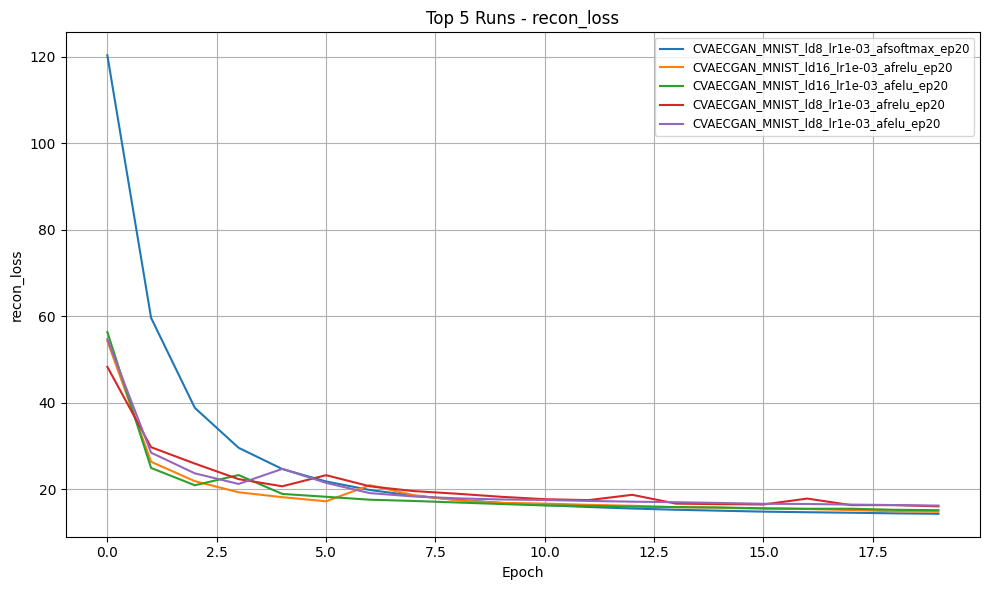

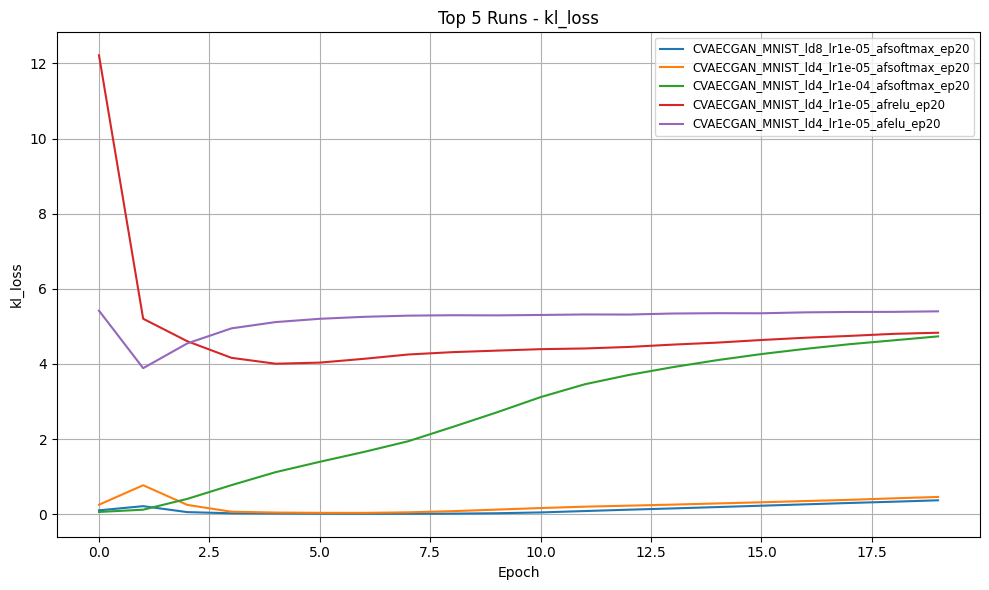

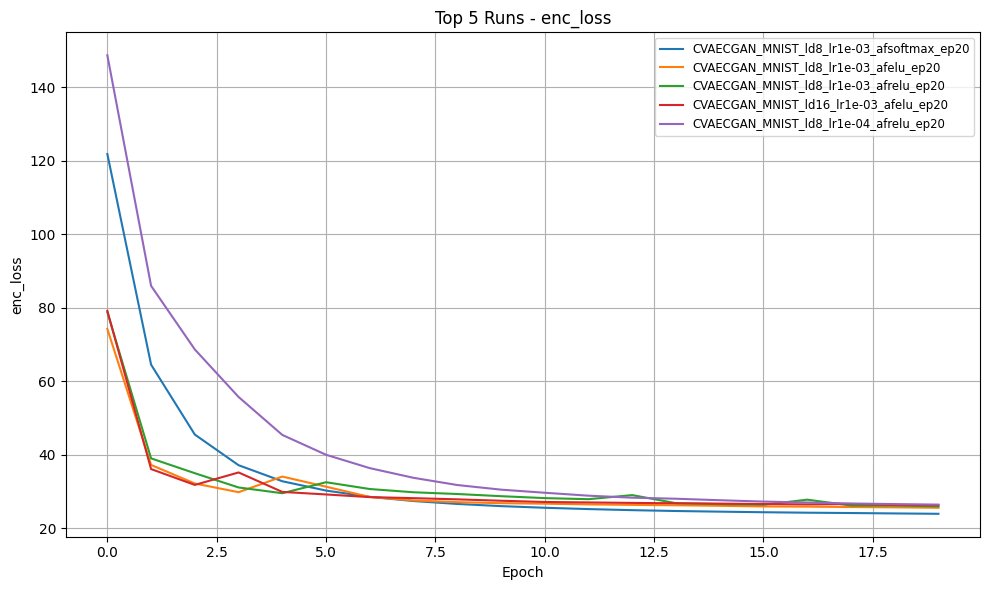

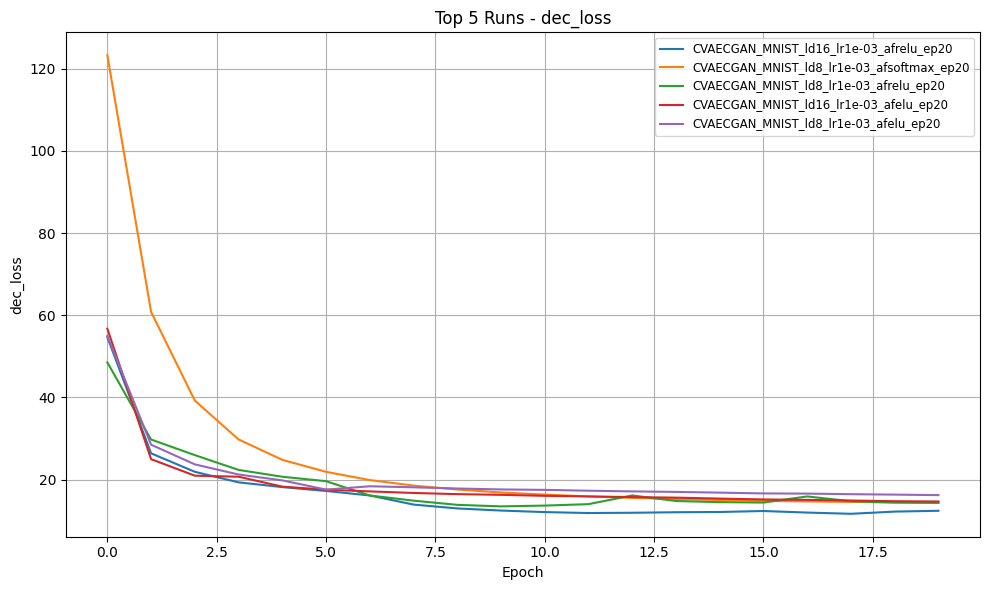

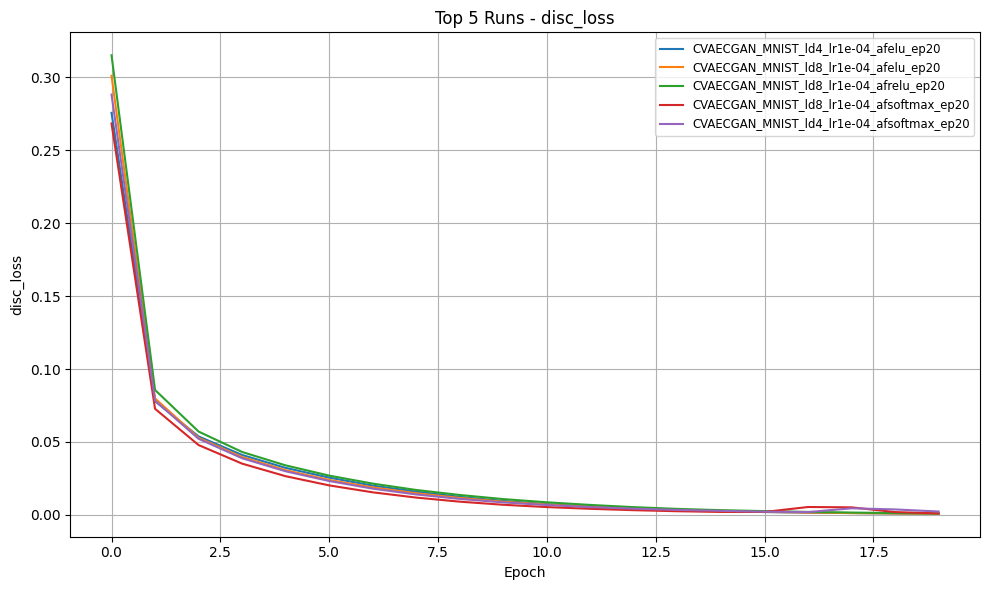

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_hpo(results, output_dir, max_curves=5):
    """
    Plot training loss curves from top-k HPO runs.

    Args:
        results (list of dict): Each dict contains 'run_name' and loss values.
        output_dir (str): Path where training logs are stored.
        max_curves (int): Number of top runs to plot per loss type.
    """
    log_file = "training_log.csv"
    loss_types = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]

    for loss in loss_types:
        plt.figure(figsize=(10, 6))

        top_runs = sorted(results, key=lambda r: r.get(loss, float('inf')))[:max_curves]
        plotted = 0

        for run in top_runs:
            log_path = os.path.join(output_dir, run["run_name"], log_file)

            if not os.path.isfile(log_path):
                print(f"  Missing: {log_path}")
                continue

            df = pd.read_csv(log_path)
            if loss not in df:
                print(f"  '{loss}' not found in: {log_path}")
                continue

            plt.plot(df[loss], label=run["run_name"])
            plotted += 1

        if plotted == 0:
            print(f"No valid logs for '{loss}'")
            continue

        plt.title(f"Top {max_curves} Runs - {loss}")
        plt.xlabel("Epoch")
        plt.ylabel(loss)
        plt.legend(fontsize="small")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
sort_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]
top_k = 5
for key in sort_keys:
    results_s = sorted(results, key=lambda x: x[key])
plot_hpo(results_s, output_dir, max_curves=5)

All the line get convergenced.


Learning Rate: Lower learning rates (e.g., 1e-05) are important for good KL divergence, especially when combined with softmax. Higher learning rates (1e-03, 1e-04)  can improve reconstruction and other losses when used with relu, but they tend to hurt KL performance.


Activation Function: Softmax helps manage the KL loss better. ReLU often gives better reconstruction and other losses, but may lead to worse KL results.